In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import Variable
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('train.csv',dtype = np.float32)
print(train_data)

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0        1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2        1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3        4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
41996    1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
41997    7.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
41998    6.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
41999    9.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel8  ...  pixel774  pixel775 

In [3]:
labels = train_data.pop('label').values
train_data = train_data.values/255

In [5]:
train_data_features, test_data_features, train_labels, test_labels = train_test_split(train_data,labels,test_size = 2000)

In [7]:
X_train = torch.from_numpy(train_data_features)
Y_train = torch.from_numpy(train_labels)
X_test = torch.from_numpy(test_data_features)
Y_test = torch.from_numpy(test_labels)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

torch.Size([40000, 784]) torch.Size([40000]) torch.Size([2000, 784]) torch.Size([2000])


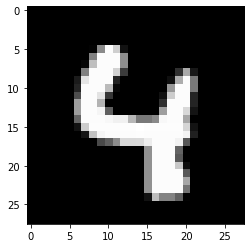

In [8]:
idx = random.randint(0,40000)
plt.imshow(X_train[idx].reshape(28,28),cmap='gray')

In [9]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.reshape(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = Net()

In [20]:
def accuracy(outputs, labels):
    probs = F.softmax(outputs, dim=1)
    max_probs, preds = torch.max(probs, dim=1)
    return (torch.sum(preds == labels).item()/len(preds))

In [21]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [26]:
batch_size = 4
train = TensorDataset(X_train,Y_train)
trainloader = DataLoader(train,batch_size=batch_size,shuffle=False)
for epoch in range(5):
    for i,data in enumerate(trainloader):
        images,labels = data
        train = Variable(images.view(batch_size,1,28,28))
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(train)
        loss = loss_function(outputs, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        X_test = X_test.view(2000,1,28,28)
        test_output = model(X_test)
        test_loss = loss_function(test_output,Y_test.type(torch.LongTensor)) 
        print(f"Epoch {epoch+1}: Accuracy = {accuracy(test_output, Y_test.type(torch.LongTensor))}")

Epoch 1: Accuracy = 0.985
Epoch 2: Accuracy = 0.986
Epoch 3: Accuracy = 0.975
Epoch 4: Accuracy = 0.9875
Epoch 5: Accuracy = 0.9875


In [27]:
df = pd.read_csv('test.csv')
test_set = df.values/255
test_set = test_set.astype(np.float32)
x = torch.from_numpy(test_set).view(-1,1,28,28)
predictions = model(x)
probs = F.softmax(predictions, dim=1)
max_probs, preds = torch.max(probs, dim=1)
submission = pd.DataFrame({"ImageId": list(range(1, len(preds)+1)),
                          "Label": preds})
submission.to_csv("sample_submission.csv", index = False, header = True)